In [1]:
# This cell is to allow automatic notebook generation for docs
# You may want to comment this out if you have paste3 installed
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.parent.parent / "src"))

# Using the PASTE2 algorithm

This noteook highlights the creation of slices (Anndata objects), usage of the `pairwise_align` and `center_align` functions of `paste3`, along with stacking and plotting functionalities.

**This notebook primarily highlights how you would use the `paste3` package in `PASTE2` (i.e. partial alignment) mode, when adjacent slices do not fully overlap in space or have different cell type compositions.**

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns

from paste3 import paste, visualization

# Read in Spatial Transcriptomics slices as AnnData objects

We provide four example ST slices from DLPFC patient 3, cropped to form partially overlapping subslices (See Figure 3A of our paper). Each slice is stored in an [AnnData](https://anndata.readthedocs.io/en/latest/) object.

In [3]:
sliceA_filename = "../../../tests/data/151673.h5ad"
sliceB_filename = "../../../tests/data/151674.h5ad"
sliceC_filename = "../../../tests/data/151675.h5ad"
sliceD_filename = "../../../tests/data/151676.h5ad"
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
sliceC = sc.read_h5ad(sliceC_filename)
sliceD = sc.read_h5ad(sliceD_filename)

Each AnnData object consists of a gene expression matrx and spatial coordinate matrix. The gene expression matrix is stored in the .X field. The spatial coordiante matrix is stored in the .obsm['spatial'] field.

In [4]:
sliceA.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 5798687 stored elements and shape (2929, 11381)>

In [5]:
sliceA.obsm["spatial"]

array([[ 5769,  2807],
       [ 4068,  9505],
       [ 3393,  7583],
       ...,
       [ 4631,  7831],
       [ 5571, 11193],
       [ 6317,  3291]])

The rows of the AnnData objects are spots. The columns are genes.

In [6]:
sliceA.obs

,in_tissue,array_row,array_col,imagerow,imagecol,sum_umi,sum_gene,subject,position,replicate,...,layer_guess_reordered_short,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_counts
AAACAATCTACTAGCA-1.3,1,3,43,126.327637,259.630972,1667,1150,Br8100,0,1,...,L1,1150,7.048386,1667.0,7.419381,22.975405,30.173965,42.171566,61.007798,1628.0
AAACACCAATAACTGC-1.8,1,59,19,427.767792,183.078314,3769,1960,Br8100,0,1,...,WM,1960,7.581210,3769.0,8.234830,25.975060,33.138764,42.531175,59.697533,3704.0
AAACAGCTTTCAGAAG-1.7,1,43,9,341.269139,152.700275,4278,2264,Br8100,0,1,...,L5,2264,7.725330,4278.0,8.361475,23.796166,30.201029,38.826554,54.698457,4217.0
AAACAGGGTCTATATT-1.8,1,47,13,362.916304,164.941500,4004,2178,Br8100,0,1,...,L6,2178,7.686621,4004.0,8.295299,24.600400,30.669331,39.185814,55.344655,3922.0
AAACAGTGTTCCTGGG-1.5,1,73,43,503.780395,256.930702,2376,1432,Br8100,0,1,...,WM,1432,7.267525,2376.0,7.773594,26.136364,33.501684,43.308081,60.774411,2339.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1.8,1,58,42,422.862301,254.410450,4324,2170,Br8100,0,1,...,WM,2170,7.682943,4324.0,8.372168,22.941721,30.388529,40.703053,57.770583,4266.0
TTGTTTCATTAGTCTA-1.8,1,60,30,433.393354,217.146722,2761,1560,Br8100,0,1,...,WM,1560,7.353082,2761.0,7.923710,26.439696,34.190511,43.824701,61.608113,2715.0
TTGTTTCCATACAACT-1.8,1,45,27,352.430255,208.415849,2322,1343,Br8100,0,1,...,L6,1343,7.203406,2322.0,7.750615,31.093885,37.941430,47.243755,63.695090,2300.0
TTGTTTGTATTACACG-1.4,1,73,41,503.735391,250.720081,2331,1420,Br8100,0,1,...,WM,1420,7.259116,2331.0,7.754481,25.139425,32.947233,42.728443,60.531961,2286.0


In [7]:
sliceA.var

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_counts
NOC2L,ENSG00000188976,Gene Expression,GRCh38,690,0.223963,0.202094,81.038747,815.0,6.704414,815.0
KLHL17,ENSG00000187961,Gene Expression,GRCh38,163,0.045342,0.044344,95.520747,165.0,5.111988,165.0
HES4,ENSG00000188290,Gene Expression,GRCh38,875,0.303105,0.264750,75.954933,1103.0,7.006695,1103.0
ISG15,ENSG00000187608,Gene Expression,GRCh38,968,0.318494,0.276490,73.399286,1159.0,7.056175,1159.0
AGRN,ENSG00000188157,Gene Expression,GRCh38,1038,0.351470,0.301193,71.475680,1279.0,7.154615,1279.0
...,...,...,...,...,...,...,...,...,...,...
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,3639,85.596596,4.461260,0.000000,311486.0,12.649113,311486.0
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,3593,9.799670,2.379516,1.264084,35661.0,10.481841,35661.0
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,1966,0.860126,0.620644,45.974169,3130.0,8.049108,3130.0
MT-CYB,ENSG00000198727,Gene Expression,GRCh38,3639,49.170376,3.915425,0.000000,178931.0,12.094761,178931.0


We can visualize the slices using [scanpy](https://scanpy.readthedocs.io/en/stable/). In this case, the .obs["layer_guess_reordered"] field stores the layer annotation of each slice, so we use this field to color each spot.

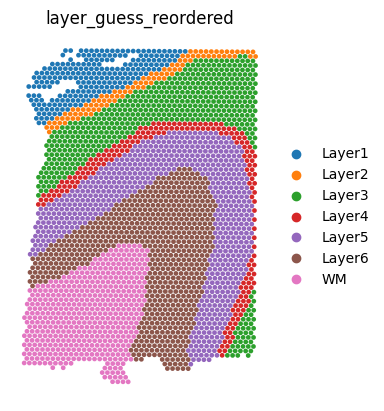

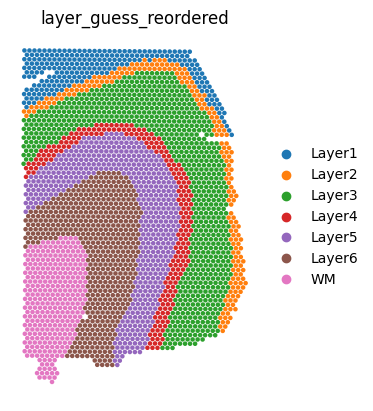

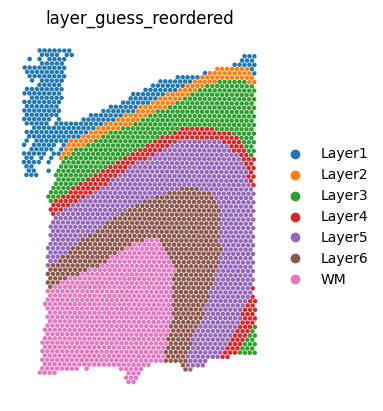

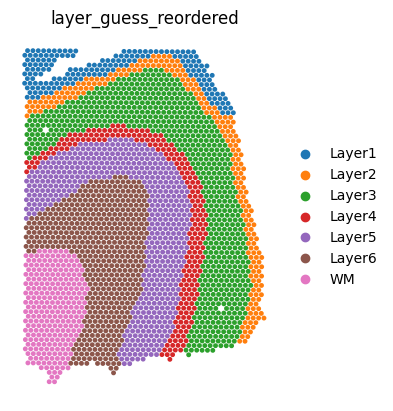

In [8]:
sc.pl.spatial(sliceA, color="layer_guess_reordered", spot_size=125, frameon=False)
sc.pl.spatial(sliceB, color="layer_guess_reordered", spot_size=125, frameon=False)
sc.pl.spatial(sliceC, color="layer_guess_reordered", spot_size=125, frameon=False)
sc.pl.spatial(sliceD, color="layer_guess_reordered", spot_size=125, frameon=False)

# Compute partial pairwise alignment using PASTE2

Give a pair of partially overlapping slices, we can use `partial_pairwise_align()` to find an alignment matrix. To call the function, you need to input the AnnData objects of the two slices, as well as a parameter s, which indicates the overlap percentage of the two slices. In this tutorial, each pair of cropped subslices overlap at 70% of the areas, so we set `overlap_fraction=0.7`. For your own datasets you should visualize the slices and manually determine the approximate overlap percentage (this parameter does not have to be very accurate).

Now we compute an alignment matrix between each pair of slices in our example dataset.

**In the calls to `pairwise_align` below, we're using maxIter=20 here to specify a maximum of 20 iterations for pairwise_align. This is only to allow this demo to run in a resonable amount of time. In a real alignment scenario, you should not include this argument**.

In [9]:
pi_AB, _ = paste.pairwise_align(sliceA, sliceB, overlap_fraction=0.7, maxIter=20)

(INFO) (paste.py) (10-Jan-25 17:08:25) GPU is not available, resorting to torch CPU.


In [10]:
pi_BC, _ = paste.pairwise_align(sliceB, sliceC, overlap_fraction=0.7, maxIter=20)

(INFO) (paste.py) (10-Jan-25 17:10:17) GPU is not available, resorting to torch CPU.


In [11]:
pi_CD, _ = paste.pairwise_align(sliceC, sliceD, overlap_fraction=0.7, maxIter=20)

(INFO) (paste.py) (10-Jan-25 17:12:04) GPU is not available, resorting to torch CPU.


Let's check the shape of each alignment matrix. For aligning a slice with n1 spots and a slice with n2 spots, the alignment matrix should be of shape (n1 * n2)

In [12]:
print(pi_AB.shape)
print(pi_BC.shape)
print(pi_CD.shape)

torch.Size([2929, 2877])
torch.Size([2877, 2873])
torch.Size([2873, 2701])


There are other optional parameters to PASTE2.partial_pairwise_align() as well. You can checkout the original function signature in the souce code with documentation.

Let's visualize the alignment between sliceA and sliceB:

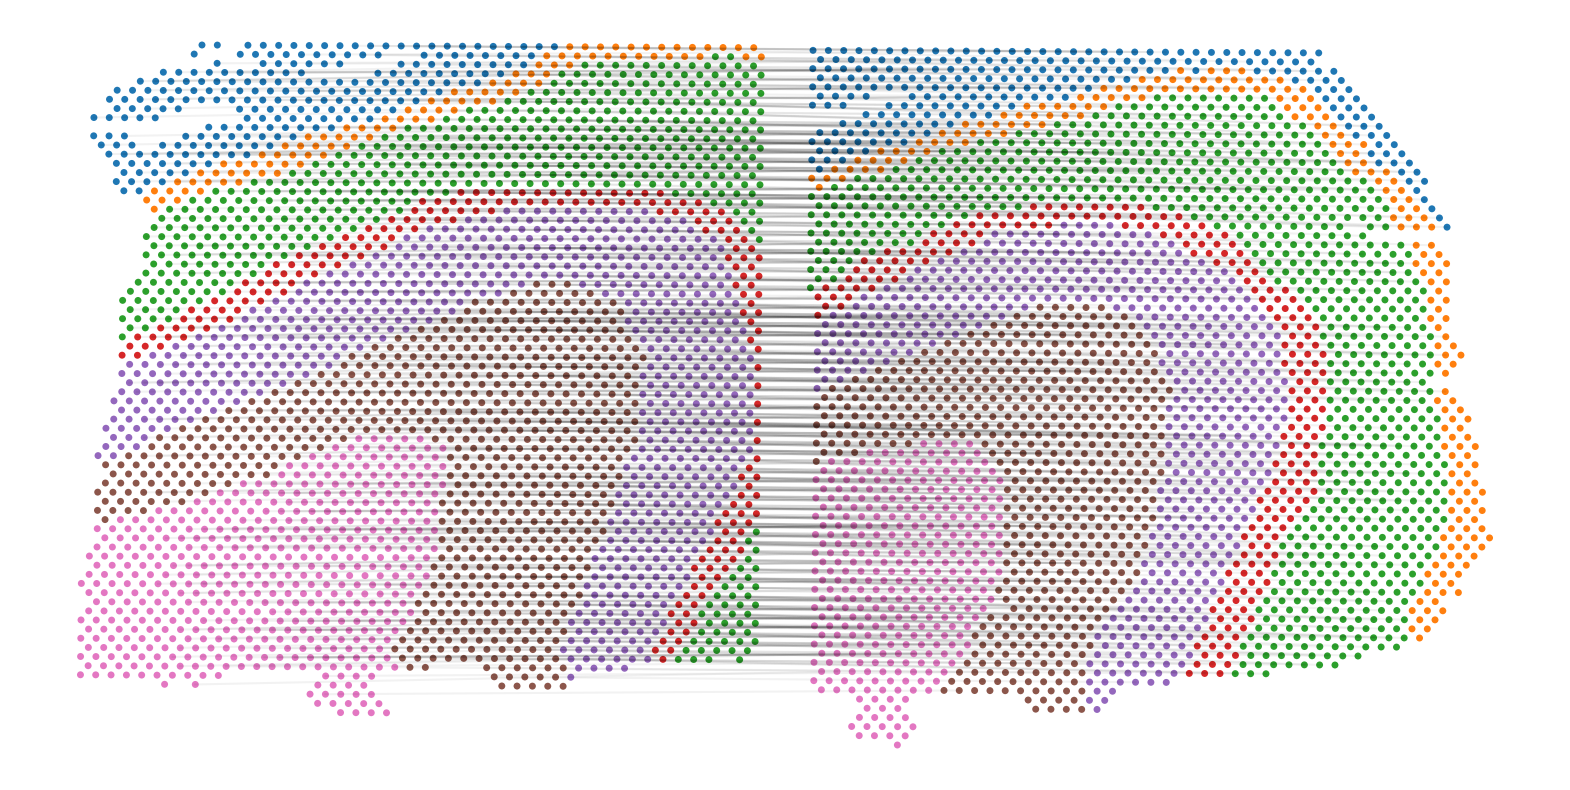

In [13]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)


def plot2D_samples_mat(xs, xt, G, alpha=0.2, top=1000, weight_alpha=False, **kwargs):
    if ("color" not in kwargs) and ("c" not in kwargs):
        kwargs["color"] = "k"
    mx = G.max().item()
    #     idx = np.where(G/mx>=thr)
    idx = largest_indices(G.cpu().numpy(), top)
    for i in range(len(idx[0])):
        plt.plot(
            [xs[idx[0][i], 0], xt[idx[1][i], 0]],
            [xs[idx[0][i], 1], xt[idx[1][i], 1]],
            alpha=alpha * (1 - weight_alpha)
            + (weight_alpha * G[idx[0][i], idx[1][i]].item() / mx),
            c="k",
        )


def plot_slice_pairwise_alignment(
    slice1, slice2, pi, alpha=0.05, top=1000, weight_alpha=False
):
    coordinates1, coordinates2 = slice1.obsm["spatial"], slice2.obsm["spatial"]
    offset = (coordinates1[:, 0].max() - coordinates2[:, 0].min()) * 1.1
    temp = np.zeros(coordinates2.shape)
    temp[:, 0] = offset
    plt.figure(figsize=(20, 10))
    plot2D_samples_mat(
        coordinates1,
        coordinates2 + temp,
        pi,
        c="k",
        alpha=alpha,
        top=top,
        weight_alpha=weight_alpha,
    )
    plt.scatter(
        coordinates1[:, 0],
        coordinates1[:, 1],
        linewidth=0,
        s=100,
        marker=".",
        color=list(
            slice1.obs["layer_guess_reordered"].map(
                dict(
                    zip(
                        slice1.obs["layer_guess_reordered"].cat.categories,
                        slice1.uns["layer_guess_reordered_colors"],
                        strict=False,
                    )
                )
            )
        ),
    )
    plt.scatter(
        coordinates2[:, 0] + offset,
        coordinates2[:, 1],
        linewidth=0,
        s=100,
        marker=".",
        color=list(
            slice2.obs["layer_guess_reordered"].map(
                dict(
                    zip(
                        slice2.obs["layer_guess_reordered"].cat.categories,
                        slice2.uns["layer_guess_reordered_colors"],
                        strict=False,
                    )
                )
            )
        ),
    )
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.show()


plot_slice_pairwise_alignment(sliceA, sliceB, pi_AB)

# Project all slices onto the same coordiante system according to the alignment

Once the alignment matrix between each pair of adjacent slices in a sequence of consecutive slices are computed, we can use this information to project all slices onto the same 2D coordinate system. 3D reconstruction can be done by assiging a z-coordiante to each slice after the projection.

Specifically, we use visualization.partial_stack_slices_pairwise( ):

In [14]:
pis = [pi_AB, pi_BC, pi_CD]
slices = [sliceA, sliceB, sliceC, sliceD]

new_slices, _, _ = visualization.stack_slices_pairwise(slices, pis, is_partial=True)

Now let's plot the coordinates of all slices after the projection:

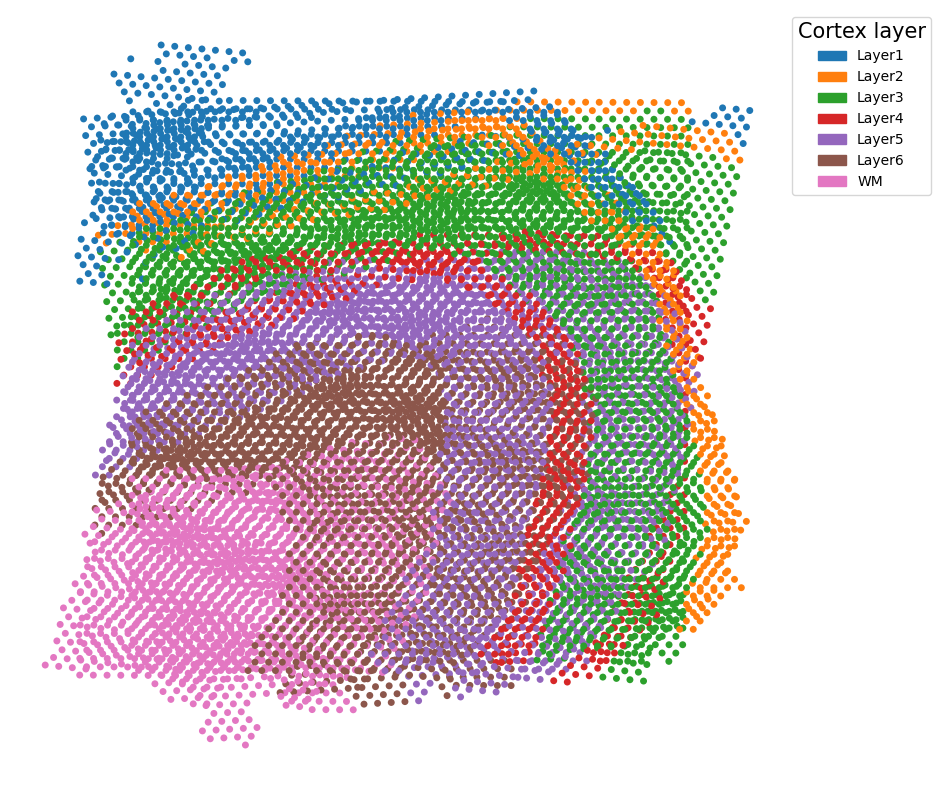

In [15]:
layer_to_color_map = {f"Layer{i + 1}": sns.color_palette()[i] for i in range(6)}
layer_to_color_map["WM"] = sns.color_palette()[6]


def plot_slices_overlap(slices, layer_to_color_map=layer_to_color_map):
    plt.figure(figsize=(10, 10))
    for i in range(len(slices)):
        adata = slices[i]
        colors = list(
            adata.obs["layer_guess_reordered"].astype("str").map(layer_to_color_map)
        )
        plt.scatter(
            adata.obsm["spatial"][:, 0],
            adata.obsm["spatial"][:, 1],
            linewidth=0,
            s=100,
            marker=".",
            color=colors,
        )
    plt.legend(
        handles=[
            mpatches.Patch(
                color=layer_to_color_map[
                    adata.obs["layer_guess_reordered"].cat.categories[i]
                ],
                label=adata.obs["layer_guess_reordered"].cat.categories[i],
            )
            for i in range(len(adata.obs["layer_guess_reordered"].cat.categories))
        ],
        fontsize=10,
        title="Cortex layer",
        title_fontsize=15,
        bbox_to_anchor=(1, 1),
    )
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.show()


plot_slices_overlap(new_slices)

Or just the first two, which reproduces Figure 3C of the paper:

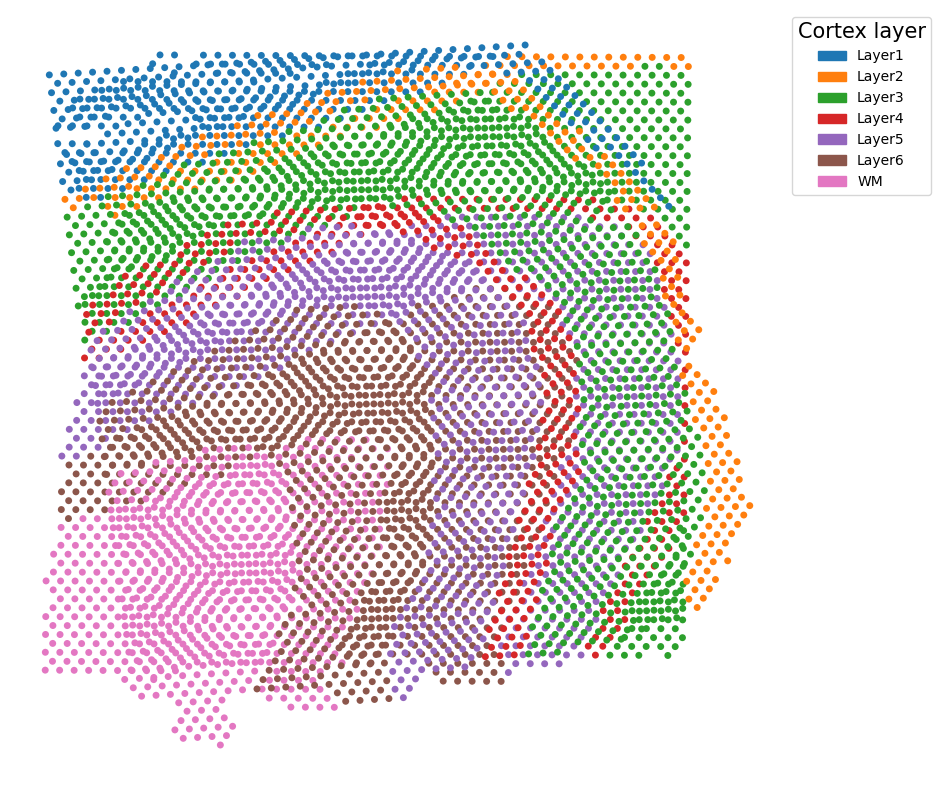

In [16]:
plot_slices_overlap(new_slices[:2])